In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [9]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-06-08 22:08:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-06-08 22:08:56 (3.93 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



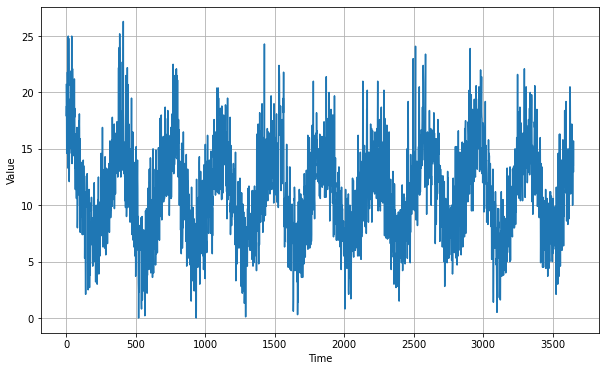

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  counter = 0
  for row in reader:
    temps.append(float(row[1]))
    counter += 1
    time_step.append(counter)
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 20ms/step - loss: 31.9561 - mae: 32.4540 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 31.2131 - mae: 31.7109 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 30.1032 - mae: 30.6008 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 25ms/step - loss: 28.7210 - mae: 29.2183 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 24ms/step - loss: 27.0082 - mae: 27.5053 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 24.8134 - mae: 25.3101 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 21.9283 - mae: 22.4247 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 25ms/step - loss: 18.2133 - mae: 18.7087 - l

(1e-08, 0.0001, 0.0, 60.0)

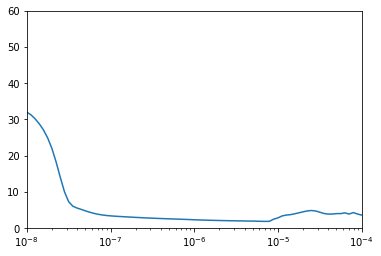

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
30/30 [==============================] - 0s 14ms/step - loss: 8.7986 - mae: 9.2837
Epoch 2/30
30/30 [==============================] - 0s 14ms/step - loss: 2.2467 - mae: 2.7063
Epoch 3/30
30/30 [==============================] - 0s 14ms/step - loss: 1.8766 - mae: 2.3300
Epoch 4/30
30/30 [==============================] - 0s 14ms/step - loss: 1.8225 - mae: 2.2745
Epoch 5/30
30/30 [==============================] - 0s 15ms/step - loss: 1.7836 - mae: 2.2346
Epoch 6/30
30/30 [==============================] - 0s 15ms/step - loss: 1.7489 - mae: 2.1989
Epoch 7/30
30/30 [==============================] - 0s 15ms/step - loss: 1.7215 - mae: 2.1709
Epoch 8/30
30/30 [==============================] - 0s 14ms/step - loss: 1.6996 - mae: 2.1484
Epoch 9/30
30/30 [==============================] - 0s 14ms/step - loss: 1.6765 - mae: 2.1243
Epoch 10/30
30/30 [==============================] - 0s 14ms/step - loss: 1.6638 - mae: 2.1108
Epoch 11/30
30/30 [==============================] - 0s 15m

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

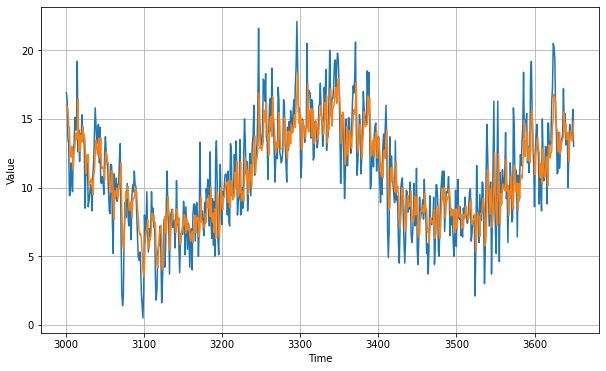

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.750765

In [23]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[16.015974  15.770732  15.773737  14.375576  14.379832  12.240609
 12.234231  13.014947  12.002443  11.341238  12.651398  12.955776
 13.974365  13.467503  13.672363  16.461573  12.635605  13.882908
 12.63835   13.820255  13.320377  14.448261  13.60887   13.858271
 13.291068  10.998448  12.367751  11.846865  12.397086  10.191698
 10.393817  10.35823   10.631909  10.318519   9.485542  10.784433
 11.233198  12.533522  13.44191   12.85437   12.384365  13.201807
 13.5801525 12.108695  13.639294  11.400838  11.532084  11.4147835
 11.210217  10.502514  12.004463  12.6377325 12.213922  11.849217
 11.705558  10.859238  10.019951   9.660147  11.229134  11.175428
  9.105627   7.6595383  9.778477   9.313457   9.6647     9.961912
  9.149261   9.910811   9.937595  11.072978  11.765536   8.42468
  6.1902204  5.4922237  6.148292   7.8472166  9.695355   9.199836
  9.385012  10.082227   8.814281   8.327142   8.896603   8.999009
  7.804302   9.029892   9.187037   9.301954   9.962776   9.484237
  9.63777 